# Time-Series analytics on sor_casa_td_trx_FC_downsample

In this notebook, we are going to analyse temporal data.


We'll perform the following analysis:
* Interpolating and smoothing of the data. If your data is irregular, it will be transformed to regular data. It can then be "smoothed" to get it to a lower granularity.
* Various plotting: we'll plot individual time series on various scales
* Aggregations on rolling windows, aka low-pass filters
* Seasonality decomposition, to separate the long-term trends from the short-term variations

Important note: this notebook does not include forecasting of time series. Please use the "Time series forecasting" notebook.

Navigate between sections

* [Setup and loading the data](#setup)
* [Interpolation and smoothing](#interpolation)
* [Raw plots](#plots)
* [Rolling windows](#window)
* [Seasonality decomposition](#seasonality)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" />

First of all, let's load the libraries that we'll use

In [1]:
%pylab inline
import dataiku                                          # Access to Dataiku datasets
import pandas as pd, numpy as np                        # Data manipulation 
import seaborn as sns                                   # Graphing
from sklearn.preprocessing import MinMaxScaler          # Rescale utility
from statsmodels.tsa.seasonal import seasonal_decompose # For signal decomposition
import warnings                                         # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


The first thing we do is now to load the dataset

Since analyzing time series requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

In [2]:
mydataset = dataiku.Dataset("sor_casa_td_trx_FC_downsample")

# Load the first 100'000 lines.
# You can also load random samples, limit yourself to some columns, or only load
# data matching some filters.
#
# Please refer to the Dataiku Python API documentation for more information
df = mydataset.get_dataframe(limit = 100000)
df = df[['posting_timestamp_parsed','c_trans_amt_sum','d_trans_amt_sum']]

### Get the columns

In [3]:
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print "Loaded dataset"
print "   Rows: %s" % df.shape[0]
print "   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns))
if not len(date_columns):
    print "No date columns were found, this is an issue. Try to parse your dates before using this notebook!"

Loaded dataset
   Rows: 37
   Columns: 3 (2 num, 0 cat, 1 date)


### Set the time dimension as index

All of our analysis will be based on time, so we set the first date as the index of our dataframe

In [4]:
time_column = df[date_columns[0]]
# We assume the time to be the first date column, uncomment this line to override
# time_column = "my_parsed_date"

df.set_index(time_column, inplace=True)
df.sort_index(ascending=True, inplace=True)
df.head()

posting_timestamp_parsed  c_trans_amt_sum  d_trans_amt_sum
posting_timestamp_parsed                                                           
2018-01-28                             2018-01-28     6.385227e+13     6.540731e+13
2018-02-04                             2018-02-04     7.643850e+13     7.140270e+13
2018-02-11                             2018-02-11     6.711164e+13     6.777934e+13
2018-02-18                             2018-02-18     5.836804e+13     6.100960e+13
2018-02-25                             2018-02-25     7.659781e+13     8.077214e+13

In [5]:
time_column.dtype

dtype('<M8[ns]')

## Interpolation and smoothing <a id="interpolation" />

Before we can dive in further analysis, we need to make sure that we have a "regular" time series, ie that there are no holes or "extraneous data".

We thus generate a "resambled dataframe".

The first operation is to select the interpolation granularity, ie the time range that we'll standardize on. The following code automatically selects an appropriate granularity based on the total time range in your data:

* Hour-based if data covers less than 1 month
* Day-based if data covers less than 3 years
* Week-based if data covers less than 10 years
* Month-based if data covers less than 30 years
* Year-based else

In [6]:
start_date = df.index.min()
end_date = df.index.max()

if (end_date - start_date) < timedelta64(1, 'M'):
    sample_freq = "1H"
elif (end_date - start_date) < timedelta64(3, 'Y'):
    sample_freq = "1D"
elif (end_date - start_date) < timedelta64(10, 'Y'):
    sample_freq = "1W"
elif (end_date - start_date) < timedelta64(30, 'Y'):
    sample_freq = "1M"
else:
    sample_freq = "1A"

print "Based on your data (timedelta: %s), chosen frequency is %s" % ((end_date-start_date), sample_freq)

Based on your data (timedelta: 252 days 00:00:00), chosen frequency is 1D


If you'd prefer to set your own sampling frequency, uncomment the following cell

In [0]:
# You can find the complete list of options at:
# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
#
# You can combine these with numerical values. For example use "2D" for a "every two days" sample rate
#
#sample_freq = "1D"

In [7]:
df_interpolate = df.resample(sample_freq, label="left", convention="e").mean()

df_interpolate = df_interpolate.interpolate(method="time")

print "Interpolated at %s, the time series has %s rows" % (sample_freq, df_interpolate.shape[0])

Interpolated at 1D, the time series has 253 rows


Let's check how our resampled time series looks (NB: we only show the first time series here)

In [10]:
# Draw original and interpolated series
#fig, ax = plt.subplots(1, figsize=(17, 5))
#df[numerical_columns[0]].plot(alpha=0.25)
#df_interpolate[numerical_columns[0]].plot()

## Plotting <a id="plots" />

### One above another, not scaled

Let's plot all of our time series, one above another (NB: scales are not the same).

Note that for display reason, we default to only plotting the first 20 time series. You can change this below.

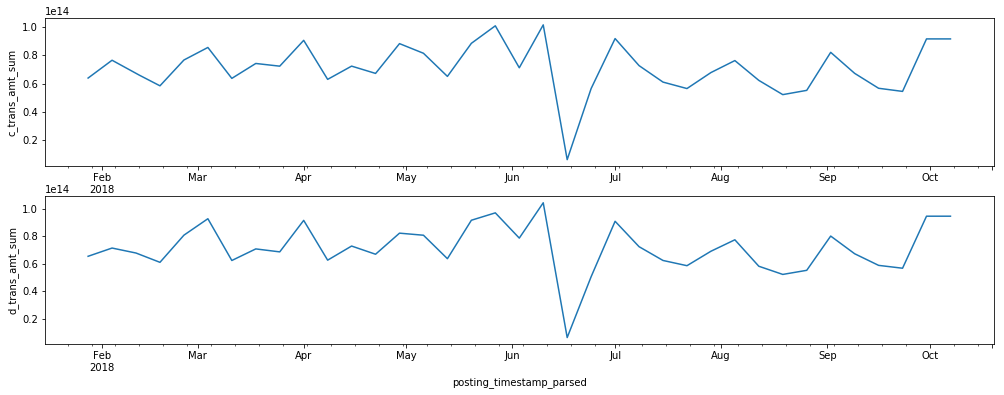

In [9]:
# Plot all time series in this dataset, with a limit of 20
lim_col = min(20, len(numerical_columns))
if lim_col == 1:
    f, ax = plt.subplots(1, figsize=(17, 3))
    df_interpolate[numerical_columns[0]].plot()
else:
    f, ax = plt.subplots(lim_col, figsize=(17, 3 * lim_col))
    for i, col in enumerate(numerical_columns[:20]):
        ax[i].set_ylabel(col)
        df_interpolate[col].plot(ax=ax[i])

### On the same graph, not scaled

Let's plot all of our time series on the same graph (with a single scale)

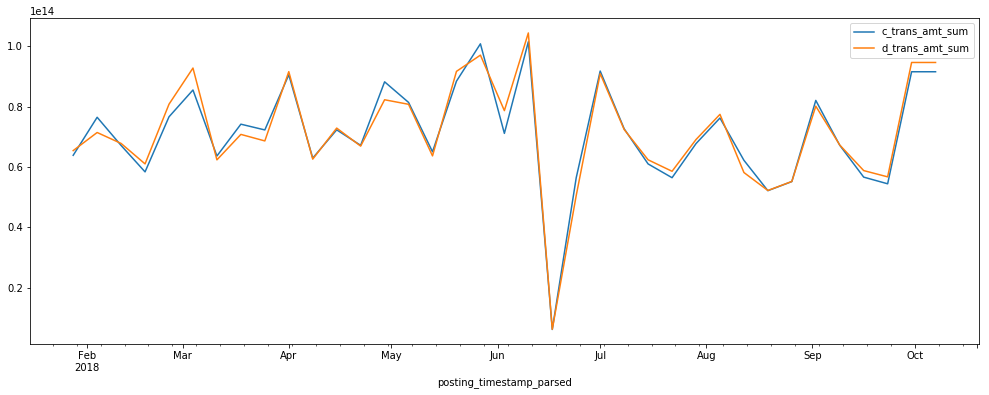

In [11]:
df_lim = df_interpolate[numerical_columns[:lim_col]]
df_lim.plot(use_index=True, figsize=(17,6))

### On the same graph, rescaled

Let's plot all of our time series on the same graph after scaling all of them on the 0-1 range

In [12]:
# The scaler doesn't accept NA values, so use filling and then drop all non-filled column
df_nona = df_interpolate.fillna(method="ffill")
columns_to_drop = []
for col in df_nona.columns:
    if df_nona[col].isnull().sum() > 0:
        columns_to_drop.append(col)
df_nona = df_nona.drop(columns_to_drop, axis=1)
plotted_columns = list(set(numerical_columns[:lim_col]) - set(columns_to_drop))

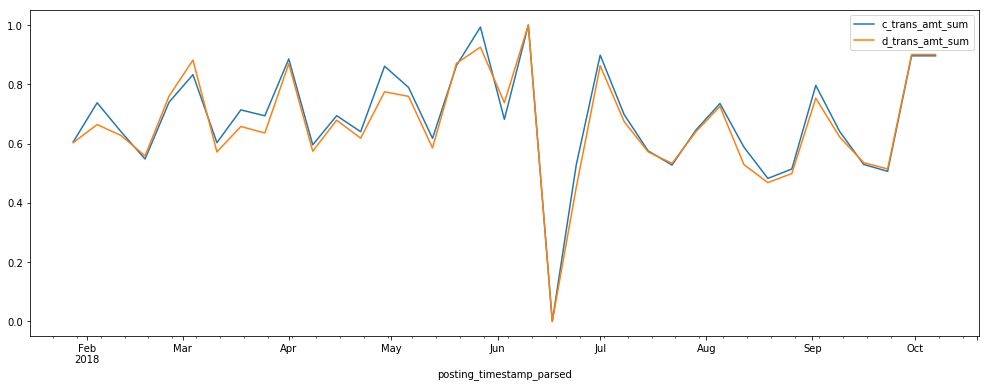

In [13]:
df_scaled = pd.DataFrame(
                    MinMaxScaler().fit_transform(df_nona[plotted_columns]),
                    columns=plotted_columns,
                    index=df_nona.index)
df_scaled.plot(use_index=True, figsize=(17, 6))

## Rolling windows (single time series) <a id="window" />

We are now going to plot the time series on various sizes of rolling windows. In essence, this is a low-pass filter on the data, which filters out high-frequency changes.

For this whole section, we'll focus on a single time series. So let's start by selecting it

In [15]:
# We assume that the time series of interest is the first column of the dataframe.
# You can replace "numerical_columns[0]" by your column of interest in the next line
series_column = numerical_columns[0]

In [16]:
df_col = df_interpolate[series_column]

In [17]:
 # Try to change these width with something smart for your data
window_widths = [5,20,50,100]

### Get mean value for varying window widths

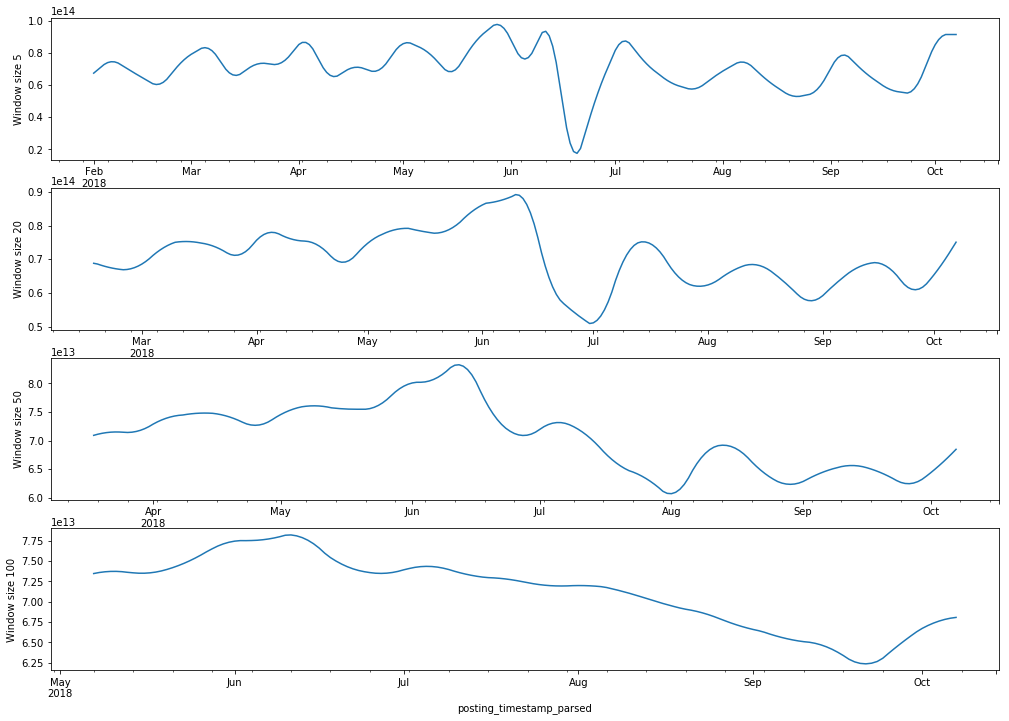

In [19]:
f, ax = plt.subplots(len(window_widths), figsize=(17, 3 * len(window_widths)))
for (i, window_size) in enumerate(window_widths):
    ax[i].set_ylabel("Window size %s" % window_size)
    pd.Series.rolling(df_col, window=window_size, center=False).mean().plot(ax=ax[i])

### Get min and max values for varying window widths

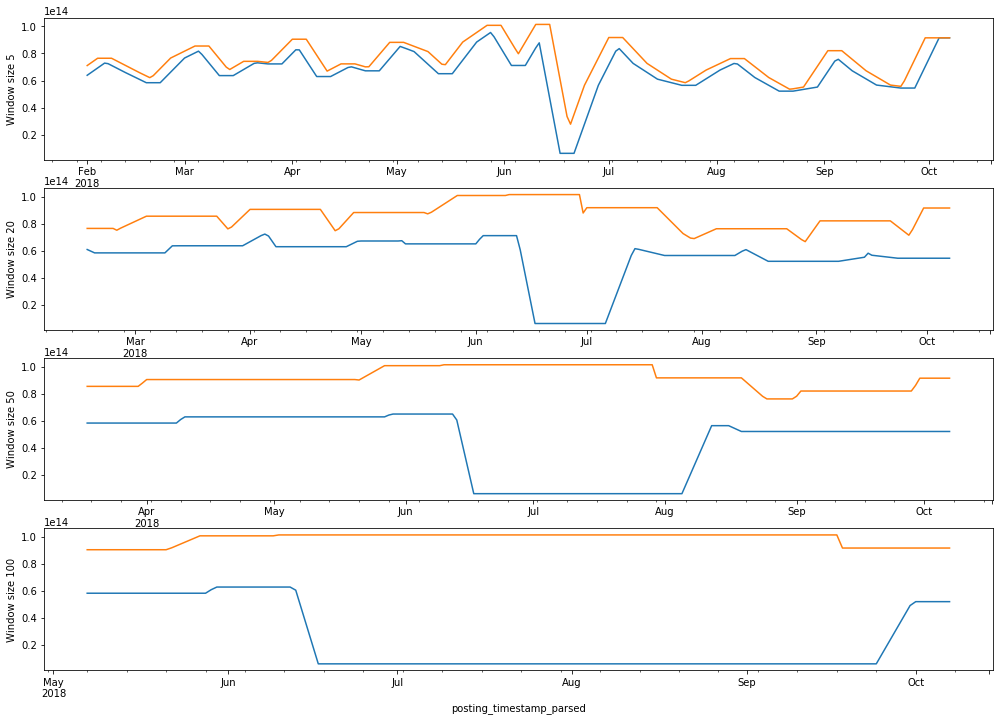

In [20]:
f, ax = plt.subplots(len(window_widths), figsize=(17, 3 * len(window_widths)))
for (i, window_size) in enumerate(window_widths): # Try to change these width with something smart for your data
    ax[i].set_ylabel("Window size %s" % window_size)
    pd.Series.rolling(df_col, window=window_size, center=False).min().plot(ax=ax[i], label="Max")
    pd.Series.rolling(df_col, window=window_size, center=False).max().plot(ax=ax[i], label="Min")

### Min, mean, max on the same graph

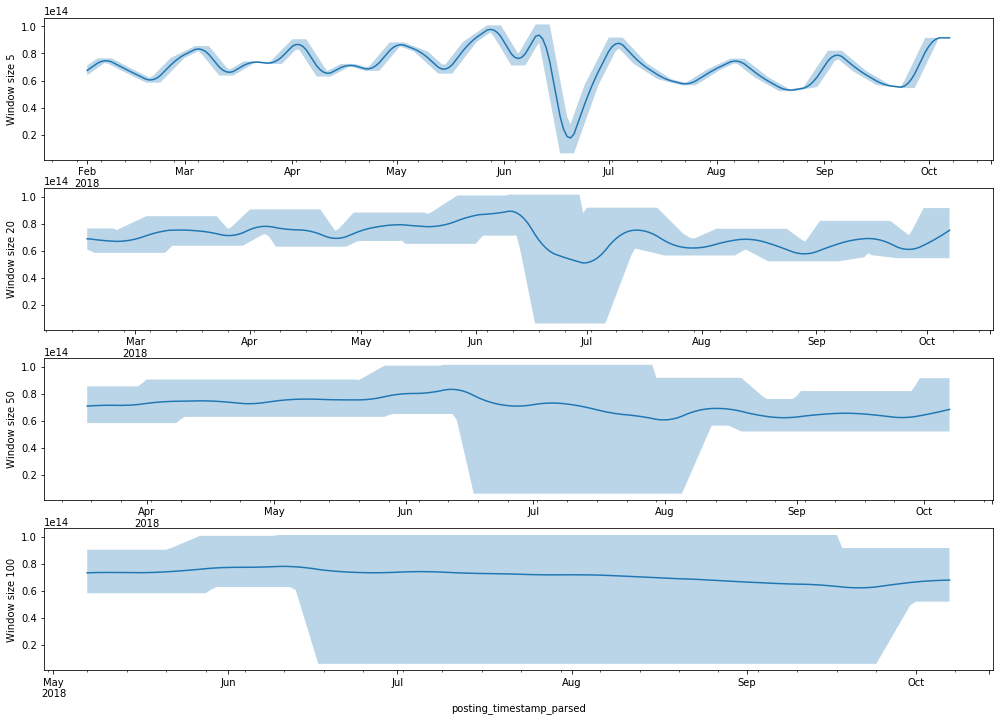

In [21]:
f, ax = plt.subplots(len(window_widths), figsize=(17, 3 * len(window_widths)))
for (i, window_size) in enumerate(window_widths): # Try to change these width with something smart for your data
    ax[i].set_ylabel("Window size %s" % window_size)
    
    rolling =  pd.Series.rolling(df_col, window=window_size, center=False)
    mean = rolling.mean()
    mean.plot(ax=ax[i], label="Mean")
    ax[i].fill_between(mean.index, rolling.min(), rolling.max(), alpha=0.3)

## STL Decomposition (single time series) <a id="seasonality" />

In many cases of time series analytics, there is a natural seasonal variation. 

A common analysis is to decompose the time series into the three main components:

* Trend: the long-term evolution of the time series
* Seasonality: the reproducible variation within each time period (as previously defined)
* Random: unpredictable variations

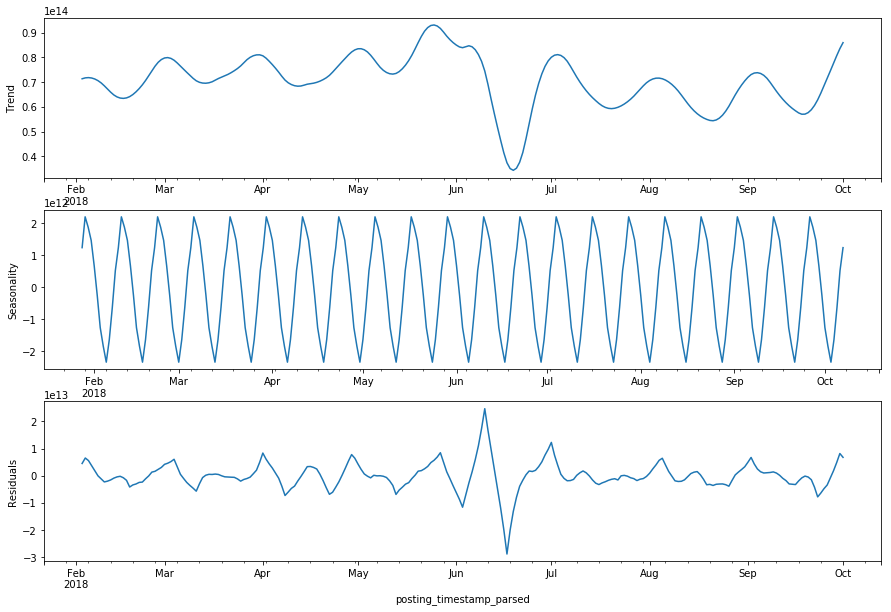

In [24]:
# The number of samples you want to use as timescale for the seasonality decomposition
if sample_freq == "1W":
    freq = 7
elif sample_freq == "1M":
    freq = 12
elif sample_freq == "1D":
    freq = 12
else:
    freq = 12 # Change this with a seasonality you think should be present in your data.

df_col_nona = df_col.fillna(method="ffill")

# Decompose time series
decomposition = seasonal_decompose(df_col_nona.values,freq=freq)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
df_stl = pd.DataFrame(index=df_col_nona.index)
df_stl["Trend"] = trend
df_stl["Seasonality"] = seasonal
df_stl["Residuals"] = residual

#Display    
f, ax = plt.subplots(3, figsize=(15, 10))
for (i, col) in enumerate(df_stl.columns):
    ax[i].set_ylabel(col)
    df_stl[col].plot(ax=ax[i])

## Signal processing <a id="signal" />

The rest of the analysis is dedicated to "signal processing" kind of analysis and is generally not suitable for general-purpose time series.

### Finding the peaks

This code finds the peaks in the input signal, and plots the detected peaks together with the original data

In [25]:
from scipy.signal import find_peaks_cwt
ts_fill = df_col.fillna(method='ffill').fillna(method='bfill')  
max_octave = np.log2(ts_fill.shape[0])
widths = 2**np.arange(0, max_octave)
peaks = find_peaks_cwt(ts_fill, widths) # list
ts_peaks = pd.Series(0, index=ts_fill.index)
ts_peaks.iloc[peaks] = 1

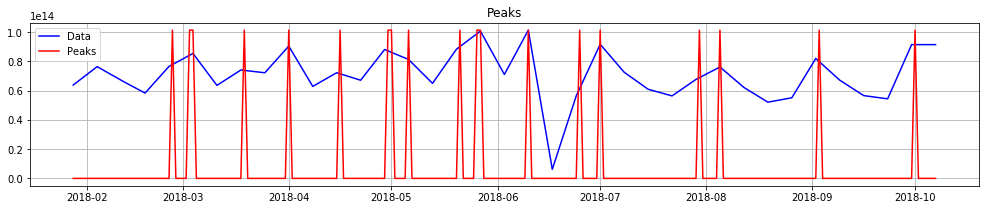

In [26]:
fig, ax = plt.subplots(1, figsize=(17, 3))

ax.plot(df_col.index, df_col, label='Data', color='blue')
ax.plot(ts_peaks.index, ts_peaks * df_col.max(), label='Peaks', color='red')
ax.set_title('Peaks')
ax.legend(loc="upper left")
ax.grid()

### Power spectrum estimation

In [27]:
time_range = df_interpolate.index.max() - df_interpolate.index.min()
sampling_frequency = df_interpolate.index.shape[0]/ (time_range.total_seconds())
print "Time series covers %s seconds (sampling freq %s Hz, sampling period: %ss)" % \
                    (time_range.total_seconds(), sampling_frequency, 1/sampling_frequency)

Time series covers 21772800.0 seconds (sampling freq 1.16200029394e-05 Hz, sampling period: 86058.4980237s)


In [28]:
from scipy import signal
d1, d2 = signal.welch(df_col.fillna(method="ffill"), sampling_frequency)

/opt/dataiku/binary/dataiku-dss-9.0.1/python.packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 253, using nperseg = 253
  .format(nperseg, input_length))


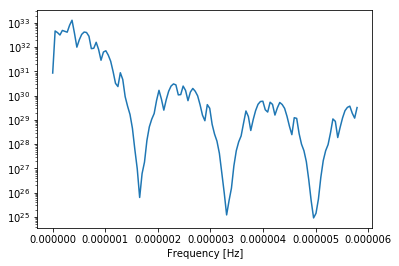

In [29]:
plt.semilogy(d1, d2)
plt.xlabel('Frequency [Hz]')
plt.show()

### Continuous Wavelet transform

NB: For best results, don't interpolate too much for this.

In [30]:
from scipy import signal
widths = np.arange(1, 10)

outputs = ["wavelet_width%i" % (int(w)) for w in widths]

df_col_filled = df_col.fillna(method="ffill")

cwtmat = signal.cwt(df_col_filled.values, signal.ricker, widths)
cwtmat_df = pd.DataFrame(cwtmat.T, columns=outputs, index=df_col.index)

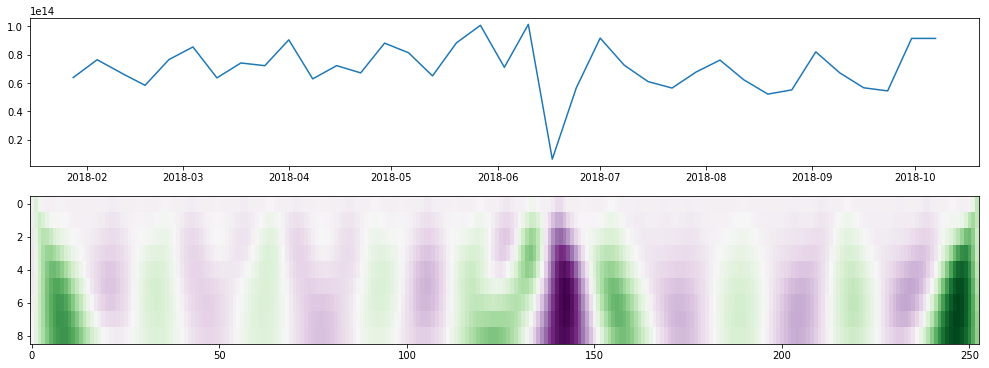

In [31]:
fig, ax = plt.subplots(2, figsize=(17, 6))
ax[0].plot(df_col_filled.index, df_col_filled.values)
ax[1].imshow(cwtmat, aspect="auto", cmap='PRGn')